In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from hyperopt.pyll import scope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [11]:
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print("Before scaling:")
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} "
      f"\nX_test: {X_test.shape}, \ny_test: {y_test.shape}")

Before scaling:
X_train: (361692, 7) 
y_train: (361692,) 
X_test: (90423, 7), 
y_test: (90423,)


In [ ]:

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) MinMaxScaler cho X & y (fit trên TRAIN) ==================
xs = MinMaxScaler()
ys = MinMaxScaler()

X_train_prepared = xs.fit_transform(X_train)
X_test_prepared  = xs.transform(X_test)

y_train_prepared = ys.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_prepared  = ys.transform(y_test.values.reshape(-1, 1)).ravel()

# ================== 4) RandomizedSearchCV (CatBoost) ==================
param_distributions = {
    "iterations": [100, 200, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10],     # <-- 'depth' (không phải 'max_depth')
}

model = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=SEED,
    thread_count=-1,            # CatBoost không có n_jobs
    verbose=0,
    allow_writing_files=False
)

ran_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,   # <-- sửa chính tả
    n_iter=10,                                  # bắt buộc với RandomizedSearchCV
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=SEED
)

ran_search.fit(X_train_prepared, y_train_prepared)

best_model   = ran_search.best_estimator_
best_params  = ran_search.best_params_
best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)

print("Best params:", best_params)
print(f"Best CV RMSE (scaled y): {best_cv_rmse:.6f}")

Best params: {'max_depth': 10, 'learning_rate': 0.1, 'iterations': 400}
Best CV RMSE (scaled y): 0.006015


In [12]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (CV metrics on scaled data) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

# Lưu toàn bộ giá trị thật và dự đoán từ các folds để scatter
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit trên train fold) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()

    X_tr_s = xs.fit_transform(X_tr)                      # fit trên X_tr, transform X_tr
    X_te_s = xs.transform(X_te)                          # transform X_te

    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()  # fit trên y_tr
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()      # transform y_te

# --- CatBoost model (train & val đều dùng dữ liệu ĐÃ SCALE) ---
    model = CatBoostRegressor(
    random_seed=SEED,
    thread_count=-1,
    verbose=False,
    max_depth= 10, learning_rate = 0.1, iterations= 400,
    loss_function = 'RMSE',

)
    model.fit(
    X_tr_s, y_tr_s,
    eval_set=(X_te_s, y_te_s),
    early_stopping_rounds=100,
    use_best_model=True
)

# --- predict & metrics (trên THANG ĐÃ SCALE) ---
    y_pred_s = model.predict(X_te_s)

    mse  = mean_squared_error(y_te_s, y_pred_s)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")

[Fold 1] (SCALED) MSE=0.000034 | RMSE=0.005835 | MAE=0.002843 | R²=0.781605
[Fold 2] (SCALED) MSE=0.000024 | RMSE=0.004881 | MAE=0.002836 | R²=0.822585
[Fold 3] (SCALED) MSE=0.000046 | RMSE=0.006747 | MAE=0.002899 | R²=0.721950
[Fold 4] (SCALED) MSE=0.000026 | RMSE=0.005100 | MAE=0.002777 | R²=0.821879
[Fold 5] (SCALED) MSE=0.000042 | RMSE=0.006470 | MAE=0.002935 | R²=0.730647
[Fold 6] (SCALED) MSE=0.000029 | RMSE=0.005377 | MAE=0.002852 | R²=0.801137
[Fold 7] (SCALED) MSE=0.000029 | RMSE=0.005350 | MAE=0.002871 | R²=0.815298
[Fold 8] (SCALED) MSE=0.000028 | RMSE=0.005247 | MAE=0.002829 | R²=0.818002
[Fold 9] (SCALED) MSE=0.000141 | RMSE=0.011869 | MAE=0.004401 | R²=0.679525
[Fold 10] (SCALED) MSE=0.000029 | RMSE=0.005387 | MAE=0.002842 | R²=0.816412

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000043
Avg MAE : 0.003008
Avg RMSE: 0.006226
Avg R²  : 0.780904


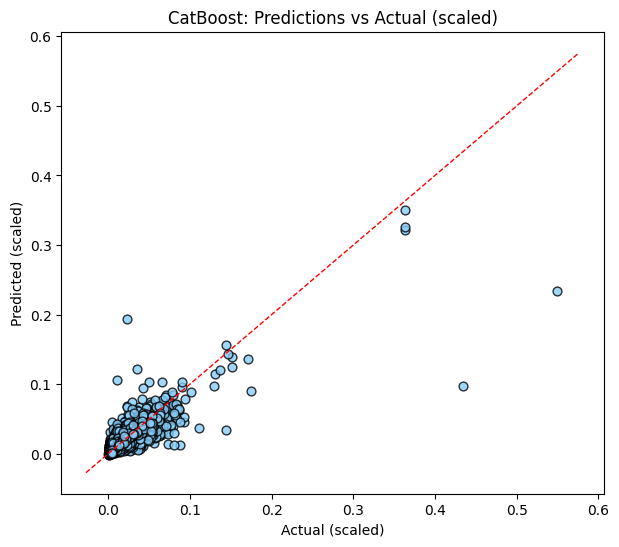

In [5]:
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt

# ================== 4) TRAIN CATBOOST (SCALED) ==================
cb = CatBoostRegressor(
    random_seed=SEED,
    eval_metric="RMSE",
    thread_count=-1,
    verbose=False,
    allow_writing_files=False
)
cb.fit(
    X_tr_s, y_tr_s
)

# ================== 5) PREDICT & SCATTER (SCALED) ==================
y_te_pred_s = cb.predict(X_te_s)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_te_s, y_te_pred_s, s=40, alpha=0.8,
           color="lightskyblue", edgecolors="k")

# Đường y = x theo giới hạn hiện tại của trục (không dùng 'lims')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([min(x0, y0), max(x1, y1)], [min(x0, y0), max(x1, y1)],
        "--", lw=1, color="red")

ax.set_title("CatBoost: Predictions vs Actual (scaled)")
ax.set_xlabel("Actual (scaled)")
ax.set_ylabel("Predicted (scaled)")
plt.show()


In [3]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts',  'nonce'
]
target = 'Gas Used'


X = df[features].astype(float)
y = df[target].astype(float)

# Hold-out chỉ để cố định tập làm việc (không dùng test ở dưới)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 2) 20 EPOCHS × 10-FOLD ==================
epochs = 20
ct = np.zeros((epochs, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(epochs):
    # shuffle train cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for train_idx, test_idx in kf.split(X_ep):
        X_tr_raw, X_tes_raw = X_ep.iloc[train_idx], X_ep.iloc[test_idx]
        y_tr_raw, y_tes_raw = y_ep.iloc[train_idx], y_ep.iloc[test_idx]

        # scale TRONG fold (fit trên train → transform train/val)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw)
        X_tes_s = xs.transform(X_tes_raw)
        y_tr_s = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_tes_s = ys.transform(y_tes_raw.values.reshape(-1,1)).ravel()


        # --- CatBoost ---
        model = CatBoostRegressor(
        random_seed=SEED,
        loss_function="RMSE",
        verbose=False, max_depth= 10, learning_rate = 0.1, iterations= 400,
        task_type = 'GPU'
    )
        model.fit(
        X_tr_s, y_tr_s,
        eval_set=(X_tes_s, y_tes_s),
        early_stopping_rounds=100,
        use_best_model=True
    )

        # metrics trên dữ liệu ĐÃ SCALE
        y_pred_s = model.predict(X_tes_s)
        mse  = mean_squared_error(y_tes_s, y_pred_s)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_tes_s, y_pred_s)
        r2   = r2_score(y_tes_s, y_pred_s)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    ct[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]

# ================== 3) OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(ct, separator=', ', prefix='array(') + ")")

final_mean = ct.mean(axis=0)
final_std  = ct.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)

array([[6.45286910e-03, 4.52280068e-05, 3.03967387e-03, 7.64331431e-01],
       [6.43787348e-03, 4.43345621e-05, 3.03203964e-03, 7.64111748e-01],
       [6.40475616e-03, 4.38153559e-05, 3.03339898e-03, 7.65777314e-01],
       [6.34688363e-03, 4.22435694e-05, 3.03077474e-03, 7.68191525e-01],
       [6.43088545e-03, 4.48880461e-05, 3.03432027e-03, 7.65546140e-01],
       [6.35114289e-03, 4.32162556e-05, 3.03267724e-03, 7.69171615e-01],
       [6.39479427e-03, 4.39338856e-05, 3.03404659e-03, 7.66298791e-01],
       [6.40596821e-03, 4.40362130e-05, 3.04133578e-03, 7.66325011e-01],
       [6.39291777e-03, 4.31902134e-05, 3.04925923e-03, 7.65973332e-01],
       [6.39468843e-03, 4.39008523e-05, 3.04342673e-03, 7.67081339e-01],
       [6.32071373e-03, 4.27661403e-05, 3.02884556e-03, 7.72308291e-01],
       [6.35058247e-03, 4.51346530e-05, 3.02931030e-03, 7.73976303e-01],
       [6.33906514e-03, 4.24398927e-05, 3.03197790e-03, 7.70189114e-01],
       [6.38695935e-03, 4.31004253e-05, 3.03220814e

In [ ]:
#optimize hyperparameters for v07

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) MinMaxScaler cho X & y (fit trên TRAIN) ==================
xs = MinMaxScaler()
ys = MinMaxScaler()

X_train_prepared = xs.fit_transform(X_train)
X_test_prepared  = xs.transform(X_test)

y_train_prepared = ys.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_prepared  = ys.transform(y_test.values.reshape(-1, 1)).ravel()

# ================== 4) RandomizedSearchCV (CatBoost) ==================
param_distributions = {
    "iterations": [100, 200, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10],     # <-- 'depth' (không phải 'max_depth')
}

model = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=SEED,
    thread_count=-1,            # CatBoost không có n_jobs
    verbose=0,
    allow_writing_files=False
)

ran_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,   # <-- sửa chính tả
    n_iter=10,                                  # bắt buộc với RandomizedSearchCV
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=SEED
)

ran_search.fit(X_train_prepared, y_train_prepared)

best_model   = ran_search.best_estimator_
best_params  = ran_search.best_params_
best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)

print("Best params:", best_params)
print(f"Best CV RMSE (scaled y): {best_cv_rmse:.6f}")

In [15]:
#entrypoint contract address v07.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (CV metrics on scaled data) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

# Lưu toàn bộ giá trị thật và dự đoán từ các folds để scatter
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit trên train fold) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()

    X_tr_s = xs.fit_transform(X_tr)                      # fit trên X_tr, transform X_tr
    X_te_s = xs.transform(X_te)                          # transform X_te

    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()  # fit trên y_tr
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()      # transform y_te

# --- CatBoost model (train & val đều dùng dữ liệu ĐÃ SCALE) ---
    model = CatBoostRegressor(
    random_seed=SEED,
    thread_count=-1,
    verbose=False,
    max_depth= 10, learning_rate = 0.1, iterations= 400,
    loss_function = 'RMSE'

)
    model.fit(
    X_tr_s, y_tr_s,
    eval_set=(X_te_s, y_te_s),
    early_stopping_rounds=100,
    use_best_model=True
)

# --- predict & metrics (trên THANG ĐÃ SCALE) ---
    y_pred_s = model.predict(X_te_s)

    mse  = mean_squared_error(y_te_s, y_pred_s)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")




[Fold 1] (SCALED) MSE=0.000007 | RMSE=0.002632 | MAE=0.001320 | R²=0.902822
[Fold 2] (SCALED) MSE=0.000017 | RMSE=0.004069 | MAE=0.002099 | R²=0.779097
[Fold 3] (SCALED) MSE=0.000007 | RMSE=0.002587 | MAE=0.001391 | R²=0.908334
[Fold 4] (SCALED) MSE=0.000007 | RMSE=0.002596 | MAE=0.001353 | R²=0.905402
[Fold 5] (SCALED) MSE=0.000146 | RMSE=0.012098 | MAE=0.001523 | R²=0.446718
[Fold 6] (SCALED) MSE=0.000007 | RMSE=0.002727 | MAE=0.001319 | R²=0.896257
[Fold 7] (SCALED) MSE=0.000025 | RMSE=0.005004 | MAE=0.002903 | R²=0.634195
[Fold 8] (SCALED) MSE=0.000010 | RMSE=0.003086 | MAE=0.001364 | R²=0.874385
[Fold 9] (SCALED) MSE=0.000186 | RMSE=0.013656 | MAE=0.001546 | R²=0.317340
[Fold 10] (SCALED) MSE=0.000007 | RMSE=0.002696 | MAE=0.001387 | R²=0.906201

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000042
Avg MAE : 0.001621
Avg RMSE: 0.005115
Avg R²  : 0.757075


In [3]:
#samples, features of entrypoint v07
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print("Before scaling:")
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} "
      f"\nX_test: {X_test.shape}, \ny_test: {y_test.shape}")

Before scaling:
X_train: (50206, 7) 
y_train: (50206,) 
X_test: (12552, 7), 
y_test: (12552,)


In [8]:
#run 20 times
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts',  'nonce'
]
target = 'Gas Used'


X = df[features].astype(float)
y = df[target].astype(float)

# Hold-out chỉ để cố định tập làm việc (không dùng test ở dưới)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 2) 20 EPOCHS × 10-FOLD ==================
epochs = 20
ct = np.zeros((epochs, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(epochs):
    # shuffle train cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_scores, mse_scores, mae_scores, r2_scores = [], [], [], []

    for train_idx, test_idx in kf.split(X_ep):
        X_tr_raw, X_tes_raw = X_ep.iloc[train_idx], X_ep.iloc[test_idx]
        y_tr_raw, y_tes_raw = y_ep.iloc[train_idx], y_ep.iloc[test_idx]

        # scale TRONG fold (fit trên train → transform train/val)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw)
        X_tes_s = xs.transform(X_tes_raw)
        y_tr_s = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_tes_s = ys.transform(y_tes_raw.values.reshape(-1,1)).ravel()


        # --- CatBoost ---
        model = CatBoostRegressor(
        random_seed=SEED,
        loss_function="RMSE",
        verbose=False, max_depth= 10, learning_rate = 0.1, iterations= 400

    )
        model.fit(
        X_tr_s, y_tr_s,
        eval_set=(X_tes_s, y_tes_s),
        early_stopping_rounds=100,
        use_best_model=True
    )

        # metrics trên dữ liệu ĐÃ SCALE
        y_pred_s = model.predict(X_tes_s)
        mse  = mean_squared_error(y_tes_s, y_pred_s)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_tes_s, y_pred_s)
        r2   = r2_score(y_tes_s, y_pred_s)

        rmse_scores.append(rmse); mse_scores.append(mse)
        mae_scores.append(mae);   r2_scores.append(r2)

    ct[ep, :] = [np.mean(rmse_scores), np.mean(mse_scores),
                 np.mean(mae_scores),  np.mean(r2_scores)]

# ================== 3) OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(ct, separator=', ', prefix='array(') + ")")

final_mean = ct.mean(axis=0)
final_std  = ct.std(axis=0, ddof=1)
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", final_mean)
print("Std  over 20 runs (RMSE, MSE, MAE, R2):", final_std)

array([[4.81808869e-03, 3.84619727e-05, 1.45477382e-03, 7.89598633e-01],
       [4.72264349e-03, 3.68551939e-05, 1.39339574e-03, 7.97795615e-01],
       [4.88110633e-03, 3.80321901e-05, 1.56848894e-03, 7.81218294e-01],
       [4.65868807e-03, 3.37589020e-05, 1.48985133e-03, 8.03297644e-01],
       [5.05318364e-03, 4.53446089e-05, 1.45615039e-03, 7.66392507e-01],
       [4.85734793e-03, 4.05909482e-05, 1.45515417e-03, 7.84309317e-01],
       [4.65438240e-03, 3.55096868e-05, 1.39278499e-03, 8.04544766e-01],
       [4.92170384e-03, 3.88392747e-05, 1.50589849e-03, 7.77469547e-01],
       [4.88471048e-03, 3.77138599e-05, 1.52754158e-03, 7.81281129e-01],
       [2.03269111e-02, 3.14135468e-03, 2.83577701e-03, 8.07446802e-01],
       [4.70428305e-03, 3.65962414e-05, 1.39608678e-03, 8.00288942e-01],
       [4.83989325e-03, 3.77980901e-05, 1.49881247e-03, 7.85893838e-01],
       [5.03354040e-03, 4.58811397e-05, 1.46675063e-03, 7.67632349e-01],
       [5.02836275e-03, 3.98647585e-05, 1.56177859e